# Process images (pilot)

Take images from raw download folder and process into appropriate data:
 - Filter images which were not downloaded
 - Compress images to smaller size
 - Filter images which do not contain the desired subject material

## Config

In [87]:

import matplotlib.pyplot as plt
from pathlib import Path
import logging
from IPython.display import Image, display
from glob import glob
from collections import defaultdict
import cv2
import pytesseract
from typing import Dict, Callable, Tuple
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.propagate = False
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['font.size'] = 12

In [63]:
# Notebook Parameters
dataset_base_path = Path('..', 'datasets', 'pilot_raw')

manual_label_template_csv = 'template_for_manually_labelling_images.csv'
manual_label_output_csv = 'manually_labelled_image_data.csv'

## Filter raw examples into usable examples

### Filter 1: Remove un-identifiable images
Some images could not be downloaded, we will filter by if trying to read the file produces an unidentifiable image error

In [3]:
dataset_folders = {
    'positive': Path(dataset_base_path, 'positive'),
    'negative': Path(dataset_base_path, 'negative')
}

In [4]:
def not_downloaded_filter(im_path: str) -> bool:
    """Return True if image file can be read, false if not identifiable"""
    try:
        plt.imread(im_path)
        return True
    except PIL.UnidentifiedImageError:
        return False

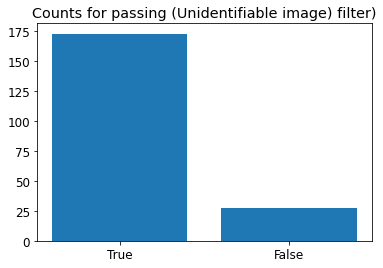

In [5]:
filter_count = defaultdict(int)
for filepath in (glob(str(dataset_folders['positive']) + '/*') +
                 glob(str(dataset_folders['negative']) + '/*')):
    filter_count[str(not_downloaded_filter(filepath))] += 1
    
plt.bar(*zip(*filter_count.items()))
plt.title("Counts for passing (Unidentifiable image) filter)")
plt.show()
 

### Filter 2: Remove images with text
Lots of images do not really display the plan but rather are a generic figure or overlay, a common theme in these images is that they have text in the image. Try to filter these out using 

In [6]:
bad_example = Path(dataset_base_path, 'positive', 'poison_ivy_plant_4.jpg')
normal_example = Path(dataset_base_path, 'positive', 'poison_ivy_plant_1.jpg')
text_example = Path(dataset_base_path, 'positive', 'poison_ivy_plant_18.jpg')

print("Normal example: ")
print(type(cv2.imread(str(normal_example))))

Normal example: 
<class 'numpy.ndarray'>


Normal example: 


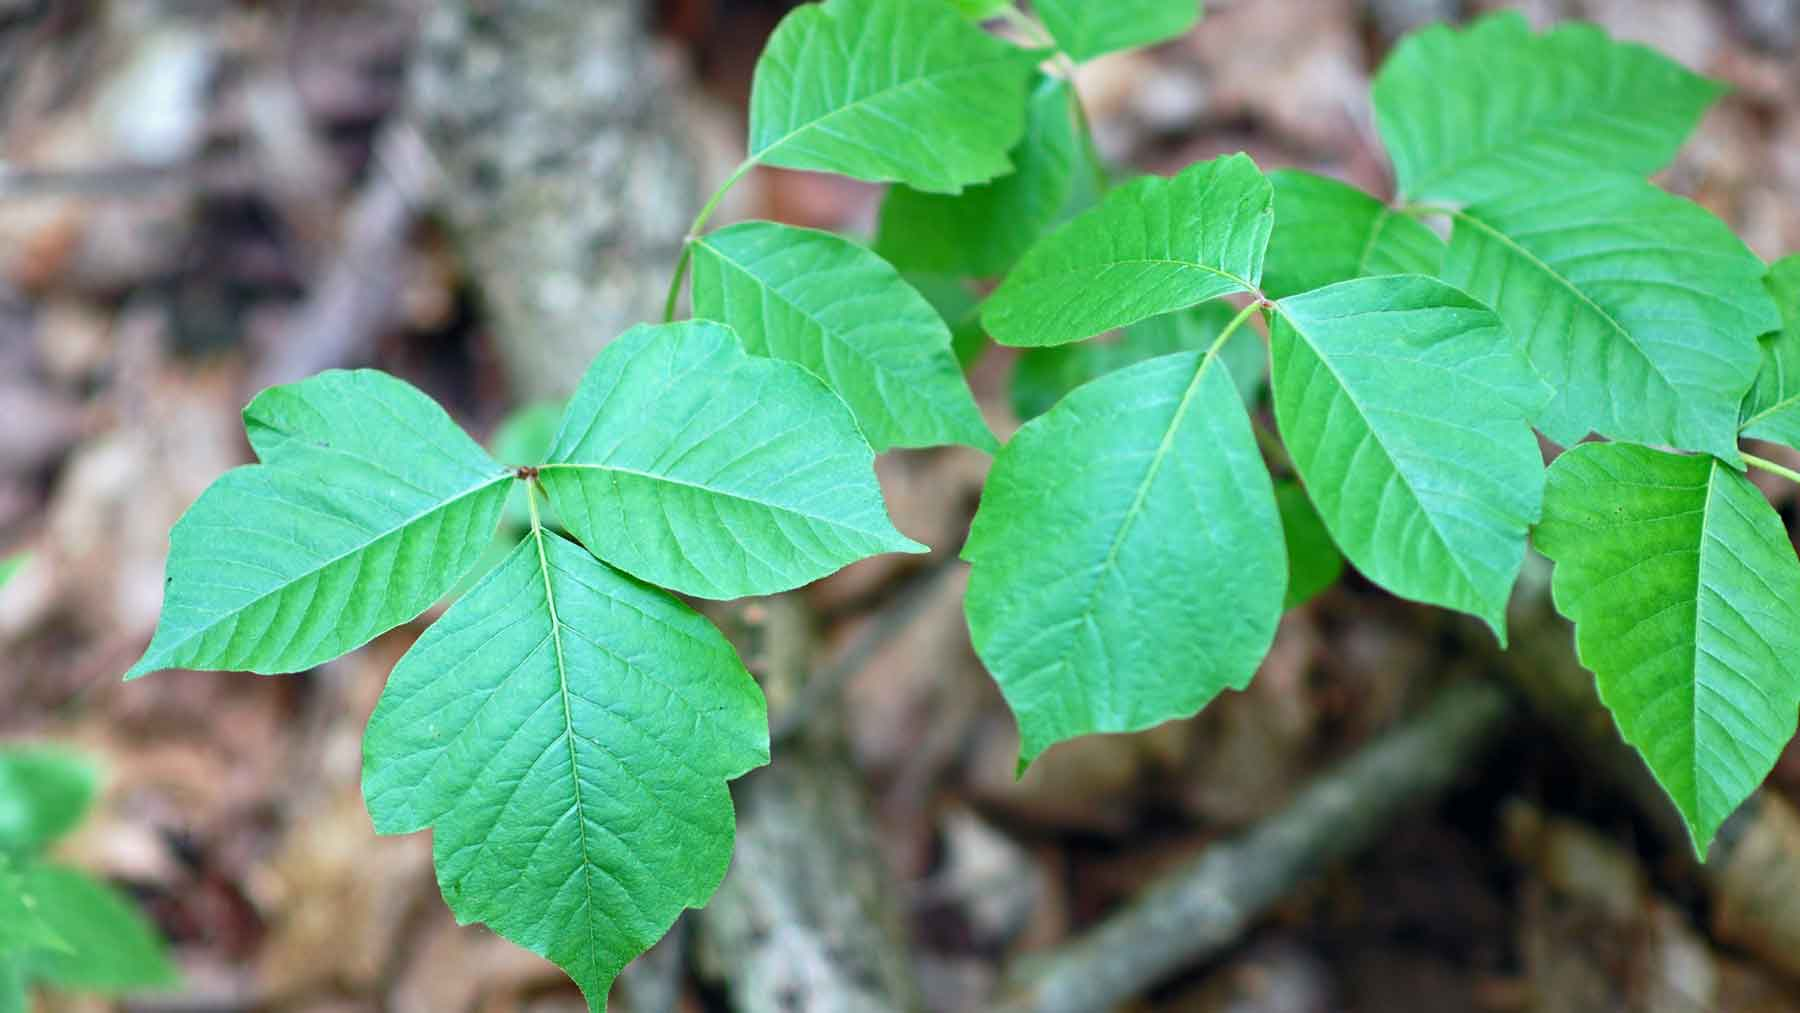

Image text:  

Text example (Bad): 


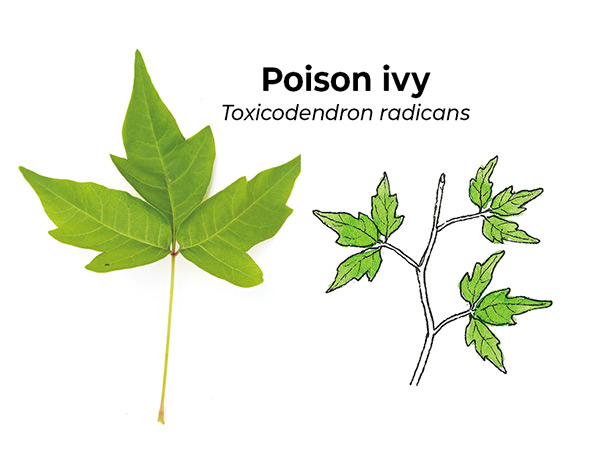

Image text: Poison ivy

Toxicodendron radicans



In [12]:
print("Normal example: ")
display(Image(filename=str(normal_example), height=200))
normal_im = cv2.imread(str(normal_example))
normal_text = pytesseract.image_to_string(normal_im)
print(f"Image text: {normal_text}")

print("Text example (Bad): ")
display(Image(filename=str(text_example), height=200))
text_im = cv2.imread(str(text_example))
text_text = pytesseract.image_to_string(text_im)
print(f"Image text: {text_text}")

None


In [27]:
def contains_text_filer(img: np.ndarray) -> bool:
    return(pytesseract.image_to_string(img).strip() == '')

In [54]:
def apply_filters_to_path(im_path:str,
                          filters: Dict[str, Callable[[np.ndarray], bool]],
                          passed_str:str = "Passed",
                          not_read_str:str = "Image_not_read") -> Tuple[bool, str]:
    """
    Apply a series of filters of to an image path
    By default checks if image can be read
    Then checks based on dictionary of {filter name: filter function}
    Returns a tuple of (Passed? (boolean), which filter failed or passed_str)
    """
    img = cv2.imread(im_path)
    if img is None:
        return (False, not_read_str) # Image could not be read
    
    for filter_name, filter_func in filters.items():
        if not filter_func(img):
            return (False, filter_name)
        
    return(True, passed_str) # No filters failed

In [31]:
test = Path(dataset_base_path, 'positive', '.')

In [40]:
for file in glob(str(Path(dataset_base_path, 'positive', '*')))[:5]:
    print(file)
    print(Path(file).name)

../datasets/pilot_raw/positive/poison_ivy_plant_1.jpg
poison_ivy_plant_1.jpg
../datasets/pilot_raw/positive/poison_ivy_plant_10.jpg
poison_ivy_plant_10.jpg
../datasets/pilot_raw/positive/poison_ivy_plant_11.jpg
poison_ivy_plant_11.jpg
../datasets/pilot_raw/positive/poison_ivy_plant_12.jpg
poison_ivy_plant_12.jpg
../datasets/pilot_raw/positive/poison_ivy_plant_13.jpg
poison_ivy_plant_13.jpg


### Test filters

In [50]:
df_ims = pd.concat([
    pd.DataFrame([[str(Path(file).absolute()), file, Path(file).name, 1]
                  for file in glob(str(Path(dataset_base_path, 'positive', '*')))],
                 columns=['full_path', 'relative_path', 'file_name', 'label']),
    pd.DataFrame([[str(Path(file).absolute()), file, Path(file).name, 0]
                  for file in glob(str(Path(dataset_base_path, 'negative', '*')))],
                 columns=['full_path', 'relative_path', 'file_name', 'label'])
]).set_index('file_name')

In [51]:
df_ims.head()

,full_path,relative_path,label
file_name,,,
poison_ivy_plant_1.jpg,/home/code/make_dataset/../datasets/pilot_raw/...,../datasets/pilot_raw/positive/poison_ivy_plan...,1
poison_ivy_plant_10.jpg,/home/code/make_dataset/../datasets/pilot_raw/...,../datasets/pilot_raw/positive/poison_ivy_plan...,1
poison_ivy_plant_11.jpg,/home/code/make_dataset/../datasets/pilot_raw/...,../datasets/pilot_raw/positive/poison_ivy_plan...,1
poison_ivy_plant_12.jpg,/home/code/make_dataset/../datasets/pilot_raw/...,../datasets/pilot_raw/positive/poison_ivy_plan...,1
poison_ivy_plant_13.jpg,/home/code/make_dataset/../datasets/pilot_raw/...,../datasets/pilot_raw/positive/poison_ivy_plan...,1


In [62]:
df_ims['temp_filter_res'] = df_ims['relative_path'].map(
    lambda rel_path: apply_filters_to_path(rel_path, filters={'has_text': contains_text_filer})
)

df_ims['passed_filters'] = df_ims['temp_filter_res'].map(lambda vals: 1 if vals[0] else 0)
df_ims['filter_result'] = df_ims['temp_filter_res'].map(lambda vals: vals[1])
df_ims.drop('temp_filter_res', axis=1, inplace=True)



<AxesSubplot:title={'center':'Counts by filter result'}>

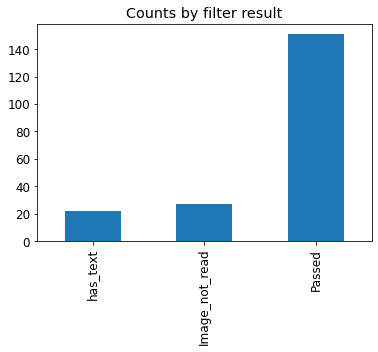

In [69]:
# Print for manual labelling
df_ims['filter_result'].value_counts().sort_values().plot(kind = 'bar',
                                                          title='Counts by filter result')

### Veryify filters manually

In [71]:
df_ims['label'].to_csv(manual_label_template_csv)

(Images were manually labelled at this step based on potential filters)

In [100]:
df_labels = pd.read_csv(manual_label_output_csv, index_col=0)
df_labels.head()

,label,keep,did_not_load,has_text,has_human,wrong_colors
file_name,,,,,,
poison_ivy_plant_1.jpg,1,1,0,0,0,0
poison_ivy_plant_10.jpg,1,1,0,0,0,0
poison_ivy_plant_11.jpg,1,0,0,0,1,0
poison_ivy_plant_12.jpg,1,1,0,0,0,0
poison_ivy_plant_13.jpg,1,1,0,0,0,0


In [75]:
df_ims.head()

,full_path,relative_path,label,passed_filters,filter_result
file_name,,,,,
poison_ivy_plant_1.jpg,/home/code/make_dataset/../datasets/pilot_raw/...,../datasets/pilot_raw/positive/poison_ivy_plan...,1,1,Passed
poison_ivy_plant_10.jpg,/home/code/make_dataset/../datasets/pilot_raw/...,../datasets/pilot_raw/positive/poison_ivy_plan...,1,1,Passed
poison_ivy_plant_11.jpg,/home/code/make_dataset/../datasets/pilot_raw/...,../datasets/pilot_raw/positive/poison_ivy_plan...,1,1,Passed
poison_ivy_plant_12.jpg,/home/code/make_dataset/../datasets/pilot_raw/...,../datasets/pilot_raw/positive/poison_ivy_plan...,1,1,Passed
poison_ivy_plant_13.jpg,/home/code/make_dataset/../datasets/pilot_raw/...,../datasets/pilot_raw/positive/poison_ivy_plan...,1,1,Passed


In [97]:
df_ims['filter_result'].value_counts()

Passed            151
Image_not_read     27
has_text           22
Name: filter_result, dtype: int64

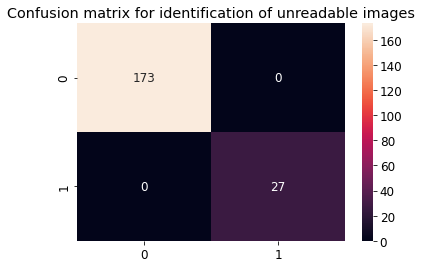

In [98]:
conf_mat = confusion_matrix(y_true=df_labels['did_not_load'],
                            y_pred=df_ims['filter_result'].map(
                                lambda res: 1 if res == 'Image_not_read' else 0))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.title('Confusion matrix for identification of unreadable images')
plt.show()

In [99]:
df_labels.columns

Index(['label', 'keep', 'did_not_load', 'text', 'human', 'colors'], dtype='object')

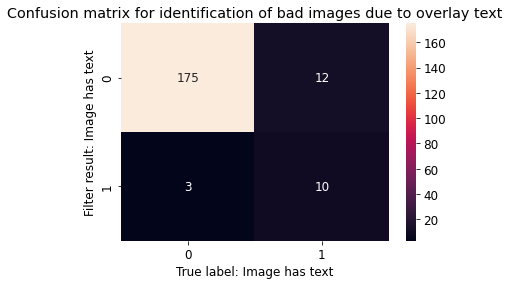

In [103]:
conf_mat = confusion_matrix(y_true=df_labels['has_text'],
                            y_pred=df_ims['filter_result'].map(
                                lambda res: 1 if res == 'has_text' else 0))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.title('Confusion matrix for identification of bad images due to overlay text')
plt.xlabel("True label: Image has text")
plt.ylabel("Filter result: Image has text")
plt.show()